# Contents
* [Objective](#objective)
* [Setup](#setup)
* [Data](#data)
* [Data Exploration](#data-exploration)
* [Research](#research)
* [Preprocessing](#preprocessing)
* [Model](#model)

# Objective
Predict pKi against different kinases given molecular structure in SMILES format

# Setup

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
from mordred import Calculator, descriptors
from rdkit import Chem
from sklearn.preprocessing import MinMaxScaler
import pickle
import torch
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn

# Data

In [4]:
df = pd.read_csv('./kinase_JAK.csv')
df

,SMILES,measurement_type,measurement_value,Kinase_name
0,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,6.81,JAK2
1,C#CCCOC(=O)N1CCC(n2cc(C(N)=O)c(Nc3ccc(F)cc3)n2...,pIC50,8.05,JAK1
2,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK2
3,C#CCN(c1ccc(C#N)cn1)C1CCN(c2ncnc3[nH]ccc23)C1,pIC50,10.26,JAK1
4,C#CCNCC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1,pIC50,7.36,JAK2
...,...,...,...,...
10720,N#CCC1(n2cc(C(N)=O)c(Nc3ccnc(F)c3)n2)CCC(NCc2c...,pIC50,6.00,JAK2
10721,N#CCC1(n2cc(C(N)=O)c(Nc3ccnc(F)c3)n2)CCC(NCc2c...,pIC50,7.07,JAK1
10722,N#CC1CCCCC1n1cc(C(N)=O)c(Nc2ccnnc2)n1,pIC50,7.55,JAK2
10723,N#CC1CCCCC1n1cc(C(N)=O)c(Nc2ccnnc2)n1,pIC50,8.52,JAK1


# Data Exploration

<AxesSubplot:>

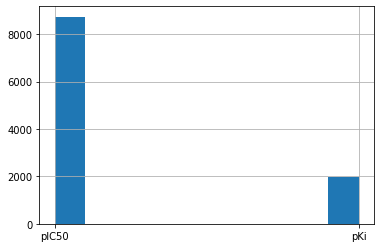

In [6]:
df['measurement_type'].hist()

We want to predict pKi, but it is a smaller subset of the total measurements.

Text(0.5, 1.0, 'pCI50 vs pKi')

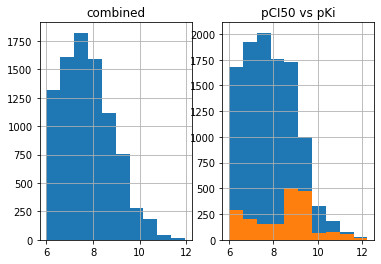

In [19]:
fig, axes = plt.subplots(1, 2)
df['measurement_value'].hist()
df[df['measurement_type']=='pIC50']['measurement_value'].hist(ax=axes[0])
df[df['measurement_type']=='pKi']['measurement_value'].hist(ax=axes[1])
axes[0].set_title('combined')
axes[1].set_title('pCI50 vs pKi')

pCI50 and pKi have similar enough distributions that we can treat them similarly but not the same. As we don't have a lot of pKi measurement_values, we want to enhance our dataset with pC150 measurement_values. Hopefully, by treating the 'measurement_type' as a feature, the model can build an intuition between the two.

<AxesSubplot:>

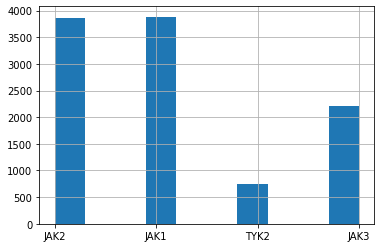

In [20]:
df['Kinase_name'].hist()

kPi to TYK2 kinase might be the hardest to predict given it has the lowest supporting data

# Research

Ki refers to inhibition constant for the binding of an inhibitor to an enzyme. The binding equilibrium depends on the machanism of inhibition: comnpetitive, uncompetitive, non-competitive, and mixed.
CI50 refers to the concentration of inhibitor required to reduce activity to 50% of the uninhibited value. These values are highly depended on  mesaurement conditions and are less precise than Ki.
https://www.sciencesnail.com/science/the-difference-between-ki-kd-ic50-and-ec50-values

Pinheiro et al show that we can predict properties using SMILES which is advantagous due to its simplicity. Let's follow a similar approach

# Preprocessing

In [21]:
# Generate dummies for 'measurement_type' and 'Kinase_name'
x = pd.concat([df, pd.get_dummies(df['Kinase_name'])], axis=1)
x = pd.concat([x, pd.get_dummies(df[['measurement_type']])], axis=1)

In [22]:
# Drop 'measurement_type' and  Kinase_name columns. 
# Also temporarily drop SMILES and set all data to same type.
x = x.drop(['measurement_type', 'Kinase_name', 'SMILES'], axis=1).astype('float32')
x['SMILES'] = df.SMILES
y = x['measurement_value']
x = x.drop(['measurement_value'], axis=1)

Get Chem data

In [31]:
chem_calc = Calculator(descriptors, ignore_3D=True)
x['molecule'] = x['SMILES'].apply(Chem.MolFromSmiles)
x_descriptors = chem_calc.pandas(x['molecule'])

/home/george/.virtualenvs/kinase_inhibitors/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/george/.virtualenvs/kinase_inhibitors/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/george/.virtualenvs/kinase_inhibitors/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/george/.virtualenvs/kinase_inhibitors/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/george/.virtualenvs/kinase_inhibitors/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.redu

Select only numerical features with some sort of variance

In [33]:
descriptors_numeric = x_descriptors.select_dtypes(include='number').astype('float32')
descriptors_numeric = descriptors_numeric.loc[:, descriptors_numeric.var() > 0]

Combine descriptor data with original data and the no longer needed columns

In [35]:
features = pd.concat([x, descriptors_numeric], axis=1)
features.drop(['SMILES', 'molecule'], inplace=True, axis=1)

Save these feature columns for later

In [36]:
model_columns = pd.DataFrame({}, columns=features.columns)
model_columns.to_csv('model_columns.csv', index=False)

Fit scaler to features and save for later inference

In [46]:
scaler = MinMaxScaler()
scaler.fit(features)
pickle.dump(scaler, open('scaler.pkl', 'wb+'))

Load our scaler and model columns then scale features

In [47]:
scaler = pickle.load(open("scaler.pkl", "rb"))
mol_columns = pd.read_csv('model_columns.csv').columns
features_scaled = pd.DataFrame(scaler.transform(features), columns=model_columns.columns)

Make tensor from our features and targets

In [53]:
features_tensor = torch.tensor(features_scaled.values)
targets_tensor = torch.tensor(y.values)

# Create Dataloader

In [60]:
x_train, x_test, y_train, y_test = train_test_split(features_tensor, targets_tensor, test_size=0.2, random_state=1)

Update dataset class

In [72]:
class data_set(Dataset):
    def __init__(self, data_):
        self.data = data_
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index):
        return self.data[index]

In [73]:
training_data = torch.utils.data.TensorDataset(x_train, y_train) 
testing_data = torch.utils.data.TensorDataset(x_test, y_test)

training_data = data_set(training_data)
testing_data = data_set(testing_data)
  
training_dataloader = DataLoader(training_data)
testing_dataloader = DataLoader(testing_data)

# Model

Use CPU or GPU

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


Define model. Using Sequential model with Linear and ReLU as found in literature. Set nodes to the order of our input data dimensions.

In [79]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1303, 8580),
            nn.ReLU(),
            nn.Linear(8580, 1303),
            nn.ReLU(),
            nn.Linear(1303, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = x.float()
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1303, out_features=8580, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8580, out_features=1303, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1303, out_features=1, bias=True)
  )
)


Use 0.001 learning rate and Mean Squared Error for our loss function as seen in literature

In [80]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.MSELoss() 

In [87]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.float()
        y = y.float()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 1000 == 0:
            loss = loss.item()
            current_item = batch
            print(f'Loss: {loss:>5f}  currently at: {current_item:>5d}/{size:>5d}')

In [88]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Test Error Avg loss: {test_loss:>5f}")

In [89]:
epochs = 2

In [90]:
for e in range(epochs):
    print(f"Epoch: {e+1}")
    print(f'Training {e+1}/{epochs}...')
    train(training_dataloader, model, loss_fn, optimizer)
    print(f'Testing {e+1}/{epochs}...')
    test(testing_dataloader, model, loss_fn)
print("Model is ready for evaluation")

Epoch: 0
Training 0/2...
Loss: 0.696362  currently at:     0/ 8580
Loss: 0.000787  currently at:  1000/ 8580
Loss: 3.702524  currently at:  2000/ 8580
Loss: 3.403656  currently at:  3000/ 8580
Loss: 1.051894  currently at:  4000/ 8580
Loss: 0.526986  currently at:  5000/ 8580
Loss: 0.806022  currently at:  6000/ 8580
Loss: 0.025076  currently at:  7000/ 8580
Loss: 0.007009  currently at:  8000/ 8580
Testing 0/2...
Test Error Avg loss: 0.907933
Epoch: 1
Training 1/2...
Loss: 0.770395  currently at:     0/ 8580
Loss: 0.000495  currently at:  1000/ 8580
Loss: 4.212951  currently at:  2000/ 8580
Loss: 1.961249  currently at:  3000/ 8580
Loss: 0.655238  currently at:  4000/ 8580
Loss: 0.733659  currently at:  5000/ 8580
Loss: 0.867867  currently at:  6000/ 8580
Loss: 0.034590  currently at:  7000/ 8580
Loss: 0.003209  currently at:  8000/ 8580
Testing 1/2...
Test Error Avg loss: 0.838875
Model is ready for evaluation


[back-to-top](#contents)